In [1]:
import torch
import numpy as np
from collections import OrderedDict
from graph.matrixview import render_incidence
from engine.torchengine import AnalyticalSetSympy, EliminateAnalysisMergeResiduals, EliminateAnalysis, FunctionSympy,get_analysis_structure, ElimResidual, ParallelResiduals, ParallelAnalysis, ipoptsolver
from engine.torchdata import load_file, process_expression, process_json, load_vals, generate_optim_functions, print_formatted_table
# from engine.loaddata import process_json
# Set the print options
np.set_printoptions(formatter={'float': lambda x: "{:0.2f}".format(x).rstrip('0').rstrip('.')})
from functools import partial
from scipy.optimize import minimize
import sympy as sp
import json
from collections import namedtuple
import cyipopt

In [3]:
symb_str_mapping = {}
all_analyses = {}
disciplines = [
    # 'pearl_geom',
    # 'pearl_hydro',
    # 'pearl_mass',
    # 'pearl_prop',
    # 'pearl_power',
    # 'pearl_solar',
    # 'pearl_battery',
    'pearl_restructured',
    'pearl_prob']
flattened_output = []
equality_constraints_sympy = []
inequality_constraints_sympy = []
for file_name in disciplines:
    data = load_file(file_name)
    equality_constraints_sympy += [
        process_expression(elt, symb_str_mapping) 
        for elt in data.get('equality_constraints',[])]
    inequality_constraints_sympy += [
        process_expression(elt, symb_str_mapping) 
        for elt in data.get('inequality_constraints',[])]
    objective = data.get('objective',None)
    if objective is not None:
        objective = process_expression(objective, symb_str_mapping)
    functional_sets = data.get('functional_sets',[])
    flattened_output += functional_sets
    analysismap, symb_str_mapping = process_json(
        functional_sets, symb_str_mapping)
    all_analyses[file_name] = analysismap

In [4]:
from graph.graphutils import edges_to_Ein_Eout, sources, all_edges, all_variables, flat_graph_formulation
from graph.operators import invert_edges, sort_scc, eqv_to_edges_tree
from presolver.tearing import dir_graph, min_arc_set_assign, min_arc_set

### Load PEARL

In [5]:
idxrev = {i: elt for i, elt in 
            enumerate(symb_str_mapping.values())}
indices = {elt: torch.tensor([int(i)]) for i, elt in 
            idxrev.items()}
sets ={}
# flat sets:
idx = 0
for file_name, analysismap in all_analyses.items():
        for _,(analysis,outputvar,residual) in enumerate(analysismap):
                sets[idx] = AnalyticalSetSympy(analysis, 
                        outputvar=outputvar, indices=indices) 
                idx+=1
equality_constraints = EliminateAnalysisMergeResiduals(functions=[FunctionSympy(expr, indices)
        for expr in equality_constraints_sympy])
inequality_constraints = EliminateAnalysisMergeResiduals(functions=[FunctionSympy(expr, indices)  
        for expr in inequality_constraints_sympy])
objective = FunctionSympy(objective, indices)

## Original problem structure

In [6]:
p = load_file('pearl_params')
edges_in = {idx: tuple(str(idxrev[elt.item()]) for elt in s.analysis.structure[0] if str(idxrev[elt.item()]) not in p.keys()) for idx,s in sets.items()}
edges_out = {idx: tuple(str(idxrev[elt.item()]) for elt in s.analysis.structure[1] if str(idxrev[elt.item()]) not in p.keys()) for idx,s in sets.items()}
#edges_in_filter = {key:val for key,val in edges_in.items() if edges_in[key]}
#edges_out_filter = {key:val for key,val in edges_out.items() if edges_in[key]}
edges = (edges_in, edges_out)

In [7]:
#A = EliminateAnalysis([S.analysis for S in sets.values()])
# print_formatted_table([x0, A(x0).numpy()], indices, idxrev)

### Load polynomials

In [8]:
# data = load_file('testproblems')
# problem_id = 0
# fid, fdata = list(data.items())[problem_id]
# polynomials, indices, edges, objective = process_json(fdata)
# sets = {idx:AnalyticalSetSympy(poly, indices=indices).reassign(edges[1][idx][0],  rational=True) for idx,poly in polynomials.items()}
# fobj = FunctionSympy(objective, indices)

In [9]:
# revindices = {var.item():key for key,var in indices.items()}

## Different ways to define orders

### 1) Pure AAO/MDF/IDF

In [10]:
order = list(sorted(sets.keys()))
A = []
B = [elt for elt in order if elt not in A]
analyses = {key: s.analysis for key,s in sets.items()}
residuals = {key: s.residual for key,s in sets.items()}

### 2) User defined elimination

In [11]:
order = list(sorted(sets.keys()))
structure_in, structure_out, full_structure = get_analysis_structure(
    [sets[idx].analysis.structure_full for idx in order])
feedback = {int(elt) for elt in structure_in}.intersection({int(elt) for elt in structure_out})
A = [elt for elt in order if int(sets[elt].analysis.structure[1]) not in feedback]
B = [elt for elt in order if elt not in A]
new_order = A+B
analyses = {key: s.analysis for key,s in sets.items()}
residuals = {key: s.residual for key,s in sets.items()}

### 3) Minimum feedback elimination

In [12]:
edges_for_solving = invert_edges(*edges)
eqnidxs = list(edges[0].keys())
varidxs = all_variables(*edges_for_solving)
edges_left_right = all_edges(*edges_for_solving)
#dout = {val[0]:key for key,val in edges[1].items()}
dout = {key:val[0] for key,val in edges[1].items()}
cycles, elimset, m = min_arc_set(edges_left_right, dout, varidxs, eqnidxs, timeout=100)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2527862
Academic license 2527862 - for non-commercial use only - registered to no___@mit.edu
Set parameter WLSSecret
Set parameter LicenseID to value 2527862
Academic license 2527862 - for non-commercial use only - registered to no___@mit.edu


In [13]:
edges_new = (edges[0],
             {key:val for key,val in edges[1].items() if key not in elimset})
G = flat_graph_formulation(edges_new[0], edges_new[1], {})
A = [next(iter(elt)).name for elt in sort_scc(G) if next(iter(elt)).name not in elimset]
B = list(elimset)
order = A+B
analyses = {key: s.analysis for key,s in sets.items()}
residuals = {key: s.residual for key,s in sets.items()}

### 4) SCC

In [282]:
G = flat_graph_formulation(edges[0], edges[1], {})
order_scc = sort_scc(G)
analyses = {}
residuals = {}
A, B = [], []
for idx, elt in enumerate(order_scc):
    if len(elt) > 1:
        merge_sets = [sets[f.name] for f in elt]
        R = EliminateAnalysisMergeResiduals(functions=[s.residual for s in merge_sets])
        solvefor = torch.tensor([s.analysis.structure[1] for s in merge_sets])
        E = ElimResidual(R, solvefor, 
                        indices, solvefor_raw=True)
        analyses[idx] = E
        residuals[idx] = E
    else:
        S = sets[next(iter(elt)).name]
        analyses[idx] = S.analysis
        residuals[idx] = S.residual
    A.append(idx)

### 5) Min feedback restructure

In [92]:
xsol, model = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_output=['D_f','D_d','D_s', 'v'])
outset_minassign = dict((right, left) for left, right in edges_left_right if xsol[left, right] > 0.5)

In [93]:
len(outset_minassign)

17

In [94]:
sets_opt = {idx:s.reassign(sp.Symbol(outset_minassign.get(idx, None)), rational=True) for idx,s in sets.items()}

In [97]:
functional_sets = []
for idx, fset in sets_opt.items():
    functional_sets.append(
        {'residual':str(fset.residualexpr),
         'analysis': str(fset.expression), 
        'functionalvar': str(fset.outputvar)})
output = {'functional_sets':functional_sets}

In [98]:
# save json data
import json
with open('../applications/data/pearl_restructured.json', 'w') as f:
    json.dump(output, f, indent=4)

### Option 1

In [14]:
# Merge residuals only
solvefor = torch.tensor([])
R = EliminateAnalysisMergeResiduals(functions=[residuals[idx] for idx in B])
P = EliminateAnalysis([analyses[idx] for idx in A], [objective,R,equality_constraints,inequality_constraints])
objective_idx,residual_idx,equality_idx,inequality_idx = 0,1,2,3

### Option 2

In [16]:
elimset = [sets[idx].analysis for idx in A]
R = EliminateAnalysisMergeResiduals(elimset, 
                                    [sets[idx].residual for idx in B])
solvefor = torch.tensor([sets[idx].analysis.structure[1] for idx in B])
bnds = [(None, None) for _ in solvefor]
ipsolver = partial(ipoptsolver, bnds_problem=bnds)
S = ElimResidual(R, solvefor, indices, 
                 solver=ipsolver,
                 solvefor_raw=True)
P = EliminateAnalysis([S]+ elimset, [objective,equality_constraints,inequality_constraints])
objective_idx,residual_idx,equality_idx,inequality_idx = 0,None,1,2

### Option 3

In [17]:
T = ParallelResiduals([sets[idx].analysis for idx in B], [objective,equality_constraints,inequality_constraints])
P = EliminateAnalysis([sets[idx].analysis for idx in A], [T], flatten=True)
objective_idx,residual_idx,equality_idx,inequality_idx = 0,3,1,2

###  Debug option

In [18]:
R = EliminateAnalysisMergeResiduals(functions=[sets[idx].residual for idx in A])
solvefor = torch.tensor([sets[idx].analysis.structure[1] for idx in A])
bnds = [(None, None) for _ in solvefor]
ipsolver = partial(ipoptsolver, bnds_problem=bnds)
S = ElimResidual(R, solvefor, indices, 
                 solver=ipsolver,
                 solvefor_raw=True)
R2 = EliminateAnalysisMergeResiduals(functions= [sets[idx].residual for idx in B])
P = EliminateAnalysis([S], [objective,R2, equality_constraints,inequality_constraints])
objective_idx,residual_idx,equality_idx,inequality_idx = 0,1,2,3

### Visualize model

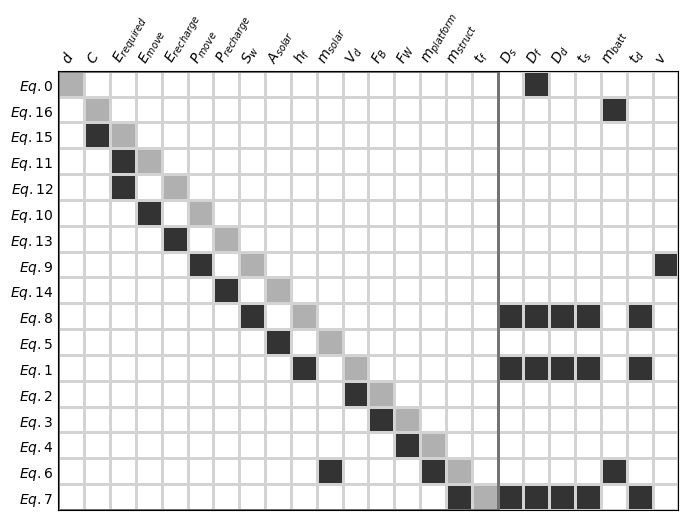

In [145]:
def transform_dict_values(d):
    return {k: tuple(f"{x.split('_')[0]}_{{{x.split('_')[1]}}}" if '_' in x else x for x in v) for k, v in d.items()}
alledges = transform_dict_values(edges[0]), transform_dict_values(edges[1]), {}
tree = (OrderedDict([(elt,1) for elt in order]),{},{})
render_incidence(alledges, tree, rotation=60, hideticks=True, rawvarname=True,
                 dispendcomp=True, figsize=((8,8)), fontsize=10, colsalignleft=True);

### Initial guess

In [132]:
# x0 = torch.ones(len(indices), dtype=torch.float64)
# x0 = 100*x0
# optimal answer
center = [ 1.0000,  1.0000,  4.0000, -2.2670,  6.9916,  1.0000, -0.0420,  1.0000,
         2.4799, -1.2697, -0.4501, -2.0834,  1.0000, -6.5000,  2.4820]

In [10]:
N = 10
Radius = 1
n = len(center)
np.random.seed(1)
points = np.random.normal(size=(N, n))
points /= np.linalg.norm(points, axis=1)[:, np.newaxis]

# Scale points by a random radius within [0, R]
scales = np.random.uniform(0, Radius, size=(N, 1))
points *= scales

In [11]:
x0 = torch.from_numpy(center+points[0])
x0 = x0.to(torch.float64)

## Optimization

In [15]:
x0 = load_vals('pearl_params', indices=indices, default=1.0)
x0 = load_vals('results', indices=indices, x0=x0)
yout = x0.clone()

In [16]:
P(x0)

[tensor([528.0872], dtype=torch.float64),
 tensor([]),
 tensor([0.], dtype=torch.float64),
 tensor([ 9.9999e-09, -1.0894e+00,  9.9988e-09, -7.5170e+02,  9.9989e-09,
          9.9968e-09], dtype=torch.float64)]

In [17]:
# print_formatted_table([yout, x0], indices, idxrev)

In [18]:
#print_formatted_table([yout, x0], indices, idxrev, subset=solvefor)

In [19]:
PA = ParallelAnalysis([elt for elt in analyses.values()])

In [20]:
# print_formatted_table([x0,PA(x0)], indices, idxrev, subset=nonpindices)

In [21]:
pindices = [val for key,val in indices.items() if str(key) in p.keys()]
dvindices = torch.tensor([elt for elt in P.structure[0] if elt not in solvefor and elt.item() not in pindices])

In [22]:
print_formatted_table([yout, x0], indices, idxrev, subset=dvindices)

D_d   D_f   D_s   m_batt v   t_d t_s
0.243 1.453 0.218 21.825 0.5 0.1 10 
0.243 1.453 0.218 21.825 0.5 0.1 10 


In [23]:
N = 10
delta = 0.5
n = len(dvindices)
rng = np.random.default_rng(seed=42)
points = rng.normal(size=(N, n))
points /= np.linalg.norm(points, axis=1)[:, np.newaxis]

# Scale points by a random radius within [0, R]
points *= delta
points += 1

#x_perturbed = x0[dvindices].detach().numpy() * points[0,:]
x0.requires_grad_(False)
for counter, idx in enumerate(dvindices):
    x0[idx] = x0[idx]* points[1,counter]
x0.requires_grad_(True);

In [24]:
P(x0)

[tensor([524.8333], dtype=torch.float64, grad_fn=<IndexBackward0>),
 tensor([]),
 tensor([-0.4957], dtype=torch.float64, grad_fn=<CatBackward0>),
 tensor([ 1.2461e-02, -1.1335e+00, -3.1400e-02, -1.3638e+03, -1.7695e-03,
         -4.2300e-02], dtype=torch.float64, grad_fn=<CatBackward0>)]

In [25]:
scaling = load_vals('pearl_scaling', indices=indices, default=1)

### Update initial values

In [26]:
numerical_values = {'D_f': 1.5, 'D_d':0.2, 'D_s':0.2, 
                    't_d':0.1, 't_f':0.1, 't_s':10,
                    'h_f':0.09}# 'v':0.6}

In [201]:
# # D_f   D_d   D_s   t_d t_f t_s h_f  v 
# # 1.549 0.242 0.218 0.1 0.1 10  0.09 0.5
# numerical_values = {'D_f': 3.7, 'D_d':1., 'D_s':0.15, 
#                     't_d':0.2, 't_f':0.2, 't_s':0.2,
#                     'h_f':0.09, 'v':0.6}
# x0.requires_grad_(False)
# for var, val in numerical_values.items():
#     x0[indices[sp.symbols(var)]] = val
# x0.requires_grad_(True);

In [202]:
# x0.requires_grad_(False)
# for idx, val in enumerate(yout):
#     x0[idx] = val.item()
# x0.requires_grad_(True);

In [203]:
# x0 = load_vals('pearl_params', indices=indices, default=1.0)
# x0 = load_vals('results', indices=indices, x0=x0)

In [27]:
optim_indices = P.structure[0]

In [28]:
p = load_file('pearl_params')
pindices = [val for key,val in indices.items() if str(key) in p.keys()]
optim_indices = torch.tensor([idx for idx in P.structure[0] if idx not in pindices])

In [29]:
print_formatted_table([x0], indices, idxrev, subset=optim_indices)

D_d   D_f   D_s   m_batt v     t_d   t_s   
0.222 1.446 0.168 26.969 0.604 0.102 13.021


In [30]:
# design_idxs = torch.tensor([indices[sp.Symbol(elt)] for elt in numerical_values.keys()])
# discipline_idxs = torch.tensor([sets[elt].analysis.structure[1] for elt in B if sets[elt].analysis.structure[1] not in design_idxs])
# optim_indices = torch.concat([discipline_idxs,design_idxs])

In [31]:
# MAKE SURE TO SET INEQUALITY DIRECTION, it is different for scipy and ipopt
xguess, obj_function, ineq_function, eq_function, dobj, dineq, deq, hobj = generate_optim_functions(P,
    optim_indices, x0, inequality_direction='negative-null', 
    objective=objective_idx, residuals=residual_idx, equalities=equality_idx, inequalities=inequality_idx)
ineqlen = len(ineq_function(xguess))
eqlen = len(eq_function(xguess))
constraints = [{'type': 'eq', 'fun': eq_function, 'jac': deq}] if eqlen >= 1 else []
constraints.append({'type': 'ineq', 'fun': ineq_function, 'jac': dineq}) if ineqlen >= 1 else []
#bnds = [(-1e3, 1e3) for _ in range(len(indices))] # can customize further
bnds = [(0, 1e7) for _ in range(len(indices))] 
bnds_problem = [bnds[elt] for elt in optim_indices]

In [32]:
Aelim = EliminateAnalysis([analyses[idx] for idx in A])
yout = Aelim(x0)
nonpindices = torch.tensor([elt for elt in indices.values() if elt.item() not in pindices])

In [33]:
print_formatted_table([yout, x0], indices, idxrev, subset=nonpindices)

A_solar D_f   d     D_d   D_s   h_f   t_d   t_s    V_d   F_B   F_W   m_platform m_solar m_batt m_struct t_f   S_w   P_move   v     E_move E_required E_recharge P_recharge C     
2.057   1.446 0.072 0.222 0.168 0.141 0.102 13.021 0.525 5.143 5.143 524.833    20.569  26.969 377.296  0.142 9.274 1363.762 0.604 4.91   9.411      9.411      217.857    15.818
1.575   1.446 0.073 0.222 0.168 0.09  0.102 13.021 0.528 5.175 5.175 528.087    15.753  26.969 390.509  0.1   9.02  751.701  0.604 2.706  7.208      7.208      166.852    12.114


In [34]:
# eps = 1e-6
# (ineq_function(xguess+eps*np.eye(len(xguess))[0])-ineq_function(xguess))/eps

In [35]:
bounds = {
    'D_f': (0.1,10),
    'D_d': (0.1,10),
    'D_s': (0.1,10),
    't_s': (0.1,10),
    't_d': (0.1,10),
    't_f': (0.1,10),
    'v': (0.5,None)
}
bnds_problem = [bounds.get(str(idxrev[elt.item()]), (0, None)) for elt in optim_indices]

In [36]:
[(idxrev[elt.item()],xguess[idx]) for idx,elt in enumerate(optim_indices)]

[(D_d, 0.2219842912764704),
 (D_f, 1.4464903224167807),
 (D_s, 0.16838545565470467),
 (m_batt, 26.96881894651662),
 (v, 0.6042154426680094),
 (t_d, 0.10176946540251572),
 (t_s, 13.020755415300098)]

In [37]:
eq_function(xguess).numpy(), ineq_function(xguess).numpy(), obj_function(xguess)

(array([-0.5]),
 array([0.01, -1.13, -0.03, -1363.76, -0, -0.04]),
 524.8332655264069)

In [38]:
dobj(xguess), dineq(xguess), #deq(xguess),

(array([-332.32, -662, -11157.22, 292.63, -16650.96, -213.49, -169.03]),
 array([[0.11, 0.1, 1.73, -0.05, 2.9, 0.1, 0.03],
        [0, -0.9, 1, 0, 0, 0, 0],
        [-0.9, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, -119, 0, 0, 0],
        [0, 0, 0, 0, 0, -1, 0],
        [0.37, 0.77, 11.79, -0.25, 14.48, 0.28, 0.16]]))

In [39]:
# np.round(np.linalg.cond(dobj(xguess)),3)

In [101]:
trace = []
def trace_points(xk):
    trace.append(np.copy(xk))

In [102]:
# # Solve the optimization problem
xsol = minimize(obj_function, xguess, bounds=bnds_problem, jac=dobj, constraints=constraints, options={'maxiter': 500, 'disp':True}, method='SLSQP', callback=trace_points)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 532.7571750985691
            Iterations: 10
            Function evaluations: 6
            Gradient evaluations: 6


In [585]:
tidx = 2
ineq_function(trace[tidx]).numpy(), eq_function(trace[tidx]).numpy(), obj_function(trace[tidx])

(array([0, 0, 0, 720.03, -0]), array([], dtype=float32), 363.47854716583134)

In [586]:
dineq(trace[tidx]), dobj(trace[tidx])

(array([[0, 0, 0, -1, 0, 0, 0, 0.9, 0],
        [0, 0.9, -1, 0, 0, 0, 0, 0, 0],
        [0.9, 0, -1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [-0.84, 0.1, 13.44, 0.59, 0.14, -0.13, -0.01, -0.41, 0]]),
 array([0, 37.77, 3929.8, 69.65, 41.78, -5.88, -0.59, -18.06, 0]))

In [588]:
xsol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 363.5835135402174
       x: [ 2.363e-01  2.363e-01  2.127e-01  9.000e-02  1.000e+01
            2.658e-10  2.658e-11  1.000e-01  7.200e+02]
     nit: 13
     jac: [ 3.162e-05  3.777e+01  3.930e+03  6.966e+01  4.179e+01
           -5.882e+00 -5.882e-01 -1.806e+01  0.000e+00]
    nfev: 45
    njev: 9

In [589]:
xsol.x

array([0.24, 0.24, 0.21, 0.09, 10, 0, 0, 0.1, 720.03])

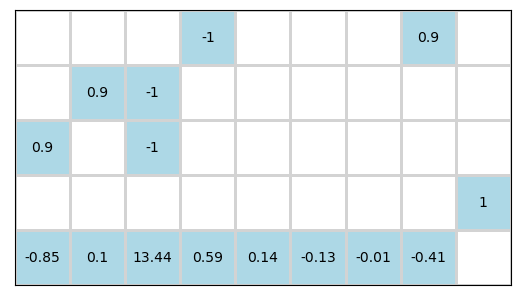

In [590]:
Am = dineq(xsol.x)
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


# Create a figure and axis
fig, ax = plt.subplots()

# Create a custom color map
cmap = ListedColormap(['white', 'lightblue'])

# Flip A upside down
A_flipped = np.flipud(Am)

# Use imshow to create a binary color map
cax = ax.pcolormesh(np.where(A_flipped != 0, 1, 0), cmap=cmap, edgecolors='lightgray', linewidth=1)

# Make cells square
ax.set_aspect('equal')

# Get the number of cells in x and y directions
num_cells_x = Am.shape[1]
num_cells_y = Am.shape[0]

# Add text at the center of the cells
for i in range(num_cells_y):
    for j in range(num_cells_x):
        if Am[i, j] != 0:
            ax.text(j+0.5, num_cells_y-i-0.5, "{:0.2f}".format(Am[i,j]).rstrip('0').rstrip('.'), ha='center', va='center')
            
ax.set_xticklabels([])
ax.set_yticklabels([])

# Optionally, remove the ticks as well
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [40]:
def all_constraints(x):
    return np.concatenate([ineq_function(x), eq_function(x)])

def all_constraints_jac(x):
    if eqlen == 0:
        return dineq(x)
    return np.concatenate([dineq(x), deq(x)], axis=0)

OptProblem = namedtuple('OptProblem', ['objective', 'constraints', 'gradient', 'jacobian', 'intermediate'])

lb,ub = zip(*bnds_problem)
cl = np.concatenate([-np.inf*np.ones(ineqlen), np.zeros(eqlen)])
cu = np.concatenate([np.zeros(ineqlen), np.zeros(eqlen)])

storeiter = [0]

def logiter(alg_mod, iter_count, obj_value, inf_pr, inf_du, mu, d_norm, regularization_size, alpha_du, alpha_pr, ls_trials):
    storeiter[0] = iter_count

# define the problem
probinfo = OptProblem(obj_function, all_constraints, dobj, all_constraints_jac, logiter)

prob = cyipopt.Problem(n=len(xguess), m=len(cu), lb=lb, ub=ub, cl=cl, cu=cu, 
                       problem_obj=probinfo)
prob.add_option('max_iter', 8000)
#prob.add_option('acceptable_tol', 1e-6)

In [41]:
xsol, optinfo = prob.solve(xguess)

In [42]:
optinfo

{'x': array([0.24, 1.45, 0.22, 21.83, 0.5, 0.1, 10]),
 'g': array([0, -1.09, 0, -751.7, 0, 0, 0]),
 'obj_val': 528.0871870973763,
 'mult_g': array([4695.03, 0, 327.29, 0, 176.81, 242.93, -21.54]),
 'mult_x_L': array([0, 0, 0, 0, 358.94, 176.81, 0]),
 'mult_x_U': array([0, 0, 0, 0, 0, 0, 1.25]),
 'status': 0,
 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}

In [43]:
equality_constraints(x0).detach().numpy(), inequality_constraints(x0).detach().numpy()

(array([-0]), array([0, -1.09, 0, -751.7, 0, 0]))

In [44]:
optim_indices

tensor([ 4,  1,  5, 17, 28,  7,  8])

In [45]:
P(x0)

[tensor([528.0872], dtype=torch.float64, grad_fn=<IndexBackward0>),
 tensor([]),
 tensor([2.2204e-16], dtype=torch.float64, grad_fn=<CatBackward0>),
 tensor([ 9.9996e-09, -1.0894e+00,  9.9949e-09, -7.5170e+02,  9.9906e-09,
          9.9931e-09], dtype=torch.float64, grad_fn=<CatBackward0>)]

## Save results

In [46]:
Aelim = EliminateAnalysis([analyses[idx] for idx in A])
yout = Aelim(x0)

In [47]:
nonpindices = torch.tensor([elt for elt in indices.values() if elt.item() not in pindices])

In [48]:
# discipline_idxs = torch.tensor([sets[elt].analysis.structure[1] for elt in A+B])
# design_idxs = torch.tensor([indices[sp.Symbol(elt)] for elt in numerical_values.keys()])
# display_indices = torch.concat([discipline_idxs,design_idxs])

In [49]:
print_formatted_table([yout, x0], indices, idxrev, subset=nonpindices)

A_solar D_f   d     D_d   D_s   h_f  t_d t_s V_d   F_B   F_W   m_platform m_solar m_batt m_struct t_f S_w  P_move  v   E_move E_required E_recharge P_recharge C     
1.575   1.453 0.073 0.243 0.218 0.09 0.1 10  0.528 5.175 5.175 528.087    15.753  21.825 390.509  0.1 9.02 751.701 0.5 2.706  7.208      7.208      166.852    12.114
1.575   1.453 0.073 0.243 0.218 0.09 0.1 10  0.528 5.175 5.175 528.087    15.753  21.825 390.509  0.1 9.02 751.701 0.5 2.706  7.208      7.208      166.852    12.114


In [227]:
results = {str(idxrev[elt.item()]): yout[elt].item() for elt in nonpindices}

In [228]:
name = 'results.json'
json_string = json.dumps(results, indent=4)
with open('../applications/data/{}'.format(name), 'w') as file:
    file.write(json_string)


## Debugging result

In [230]:
yout[indices[sp.Symbol("P_comms")]]

tensor([5.9472e-06], dtype=torch.float64, grad_fn=<IndexBackward0>)

In [49]:
[(sets[elt].outputvar, sets[elt].expression) for elt in B]

[(x_11, 5*x_10*x_7/3 - 4/3),
 (x_8, 3*(-3*x_6 - 2)/(x_12*x_3)),
 (x_6, (5*x_0 - 6)/(9*x_11*x_9)),
 (x_13, -2*x_0*x_5 - 9/2),
 (x_4, (-x_8 - 2/3)/x_10),
 (x_14, 4*(-x_1*x_3*x_9 - 1)/(3*x_11)),
 (x_9, 4/(7*x_10)),
 (x_2, 4),
 (x_10, 3*(1 - 3*x_3)/(8*x_13)),
 (x_3, (3*x_14 + 2)/(2*x_11))]

In [193]:
sets[9].analysis(yout).detach().numpy()

array([1, 1, 4, 0.12, -1335.04, 1, -0.01, 1, -50.39, -15.34, -0.04, -1.4,
       1, -6.5, -0.78])